In [1]:
from setup import setup_project_root
setup_project_root()

!pwd
!hostname

/rdma/vast-rdma/vast-home/jwdase/projects/language-detection/notebooks


node094


In [2]:
# Ensures We're Using the GPU
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'Using device: {device}')

Using device: cuda


In [3]:
languages = ['en', 'es', 'it', 'de']
data_types = ['train', 'test', 'validation']

window = 'range_5_5-6_0'

In [4]:
from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(list(languages))

print(f'Classes: {encoder.classes_}')

Classes: ['de' 'en' 'es' 'it']


In [5]:
import glob
from torch.utils.data import TensorDataset
from langaugedetection.data.tensor_construct import build_tensor

tensors = {
    'train' : {},
    'test' : {},
    'validation' : {},
}

reference = {lang : tensors.copy() for lang in languages}


for lang in languages:
    for data_type in data_types:
        base = f'/om2/user/moshepol/prosody/data/raw_audio/{lang}/spect/{data_type}/{window}/'

        paths = glob.glob(base + '*.pt')

        first_audio = True

        spectograms_tensors = []
        
        for path in paths:
            x = torch.load(path, weights_only=False)

            if first_audio:
                reference[lang][data_type] = x[0]
                first_audio = False

            # Put Tensor on range 0 --> 1
            spectograms_tensors.append(x)

        # Figrue out how to stack according to type
        tensors[data_type][lang] = spectograms_tensors.copy()


In [7]:
print(tensors['train']['en'][1].shape)
print(reference['en']['train'].shape)

torch.Size([64, 513, 344])
torch.Size([513, 344])


In [8]:
def calc_mean(tensor_list):
    '''
    Returns the mean and standard deviation
    of each tensors
    '''
    sum_ = 0.0
    sum_sq = 0.0
    count = 0

    for tensor in tensor_list:  # each tensor is e.g. [64, 1025, 172]
        sum_ += tensor.sum()
        sum_sq += (tensor ** 2).sum()
        count += tensor.numel()

    mean = sum_ / count
    std = (sum_sq / count - mean ** 2).sqrt()

    return float(mean), float(std)

In [9]:
for use, dataset in tensors.items():

    mean = 0.0
    std = 0.0

    for lang, data in dataset.items():
        mean_, std_ = calc_mean(data)

        mean += mean_
        std += std_

    mean = mean / len(dataset)
    std = std / len(dataset)

    print(f'Mean is : {mean}')
    print(f'STD is: {std}')

    for lang, data in dataset.items():
        x = [(d - mean) / std for d in data]
        tensors[use][lang] = x

Mean is : -40.028361320495605
STD is: 26.82971954345703
Mean is : -39.83550262451172
STD is: 26.838191509246826
Mean is : -39.93903732299805
STD is: 26.799057960510254


In [10]:
for use, dataset in tensors.items():
    for lang, data in dataset.items():

        mean, std = calc_mean(data)
        print(f'{use} and {lang} has mean: {mean}, std: {std}')

train and en has mean: -0.03560246154665947, std: 0.9869584441184998
train and es has mean: 0.03044043853878975, std: 1.01228666305542
train and it has mean: -0.010373804718255997, std: 1.012473464012146
train and de has mean: 0.015535852871835232, std: 0.9882809519767761
test and en has mean: -0.02780606970191002, std: 0.9919120073318481
test and es has mean: 0.02815752476453781, std: 1.0139195919036865
test and it has mean: -0.021531254053115845, std: 1.0116666555404663
test and de has mean: 0.02118007279932499, std: 0.9825022220611572
validation and en has mean: -0.039108213037252426, std: 0.9848331809043884
validation and es has mean: 0.03299262747168541, std: 1.0184694528579712
validation and it has mean: -0.009309578686952591, std: 1.0043926239013672
validation and de has mean: 0.015425127930939198, std: 0.9923046231269836


In [11]:
def flatten_data(tensors):
    result = {
        'train' : None,
        'test' : None,
        'validation' : None
    }

    for dtype, dataset in tensors.items():

        data_sets = []
        
        for lang, data in dataset.items():

            # Calculates the number of labels to assign
            values = len(data) * data[0].shape[0]

            x = [d for d in data]
            y = encoder.transform([lang] * values)

            data_sets.append(
                TensorDataset(torch.cat(x, dim=0), torch.tensor(y, dtype=torch.long))
                )

        result[dtype] = data_sets

    return result

tensor = flatten_data(tensors)

In [12]:
from torch.utils.data import ConcatDataset, DataLoader

train = ConcatDataset(tensor['train'])
test = ConcatDataset(tensor['test'])
validation = ConcatDataset(tensor['validation'])

train_loader = DataLoader(train, batch_size=256, num_workers=6, pin_memory=True, shuffle=True)
test_loader = DataLoader(test, batch_size=32, shuffle=False)
validation_loader = DataLoader(validation, batch_size=256, num_workers=6, pin_memory=True, shuffle=True)

In [13]:
print(f'Training Tensors: {len(train)}')

Training Tensors: 32000


In [14]:
import librosa
import numpy as np
from IPython.display import Audio, display
from scipy.io.wavfile import write


def play_audio(spect, return_audio, n_iter=16):
    spect_np = spect.numpy()
    S = librosa.db_to_amplitude(spect_np, ref=1.0)
    reconstructed_audio = librosa.griffinlim(S, hop_length=512, n_iter=n_iter)
    reconstructed_audio /= np.max(np.abs(reconstructed_audio))

    if return_audio is False:
        return reconstructed_audio

    return Audio(reconstructed_audio, rate=16000)


In [15]:
waveform = play_audio(reference['de']['test'], False)

waveform_int16 = (waveform * 32767).astype(np.int16)
write('it_test.wav', 16000, waveform_int16)

In [16]:
import torch.nn as nn

class LanguageDetector(nn.Module):
    def __init__(self, num_classes):
        super().__init__()

        # Convolution Layers
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)

        # Con1: (513, 344) --> (256, 172)
        # Con2: (256, 172) --> (128, 86)

        # Neuron Layers
        self.fc1 = nn.Linear(128 * 86 * 32, 1024)
        self.fc2 = nn.Linear(1024, 128)
        self.fc3 = nn.Linear(128, num_classes)

        # Normalize Layers
        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)

        # Pooling Features
        self.relu = nn.ReLU()
        self.pool = nn.MaxPool2d(kernel_size=2)
        self.dropout = nn.Dropout(p=.3)

    def forward(self, x):

        # Apply 2D Convolution
        x = self.pool(self.relu(self.bn1(self.conv1(x))))
        x = self.pool(self.relu(self.bn2(self.conv2(x))))

        # Flatten Dimensions
        x = x.view(x.size(0), -1)

        # Dense Layers
        x = self.dropout(self.relu(self.fc1(x)))
        x = self.dropout(self.relu(self.fc2(x)))
        x = self.fc3(x)

        return x

model = LanguageDetector(len(languages))

In [17]:
print(f'The device we will be using is: {device}')

The device we will be using is: cuda


In [18]:
model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=2, factor=.75, verbose=True, threshold = 1e-3
)


/om2/user/jwdase/miniconda3/envs/torchgpu/lib/python3.10/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


## Optimizers

**Adam vs. SGD**

Adam (Adaptive Movement Estimation) uses the first momentum and second momentum in calculating step distance, while SGD just uses first momentum

**Scheduler**

Works to dynamically change the learning rate based off of how much the model has learned --> in order to help it converge better in the end. We originally want our model to take large steps to get closer to convergence, then later we want small steps. This piece of code enables such bahvoir.

Types:
- ReduceLROnPlateau (Changes LR when val loss stops dropping --> need smaller learning rate to get closer)
- CosineAnnealingLR (Slowly cools down LR like simulated annealing)
- ExponentialLR (Decays LR by a fixed rate each time)

Variables:
- *mode* : 'mim' refers to loss, while 'max' refers to accuracy
- *patience* : wait x epochs before modifying LR
- *factor* : New_LR = *factor* * Old_LR
- *threshold* : Amound that it must decrease by

In [19]:
# Setting Reproducable Model
import random
import numpy as np

seed = 42
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

In [20]:
num_epochs = 100
total_loss = []
validation_loss = []
validation_accuracy = []
best_acc = 0.0


for i in range(num_epochs):
    model.train()
    running_loss = 0.0
    total_train = 0

    for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Shape [64, 1025, 172] --> [64, 1, 1025, 172]
        inputs = inputs.unsqueeze(1)

        # Forward Pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backprop + Optimizer
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        # Tracking loss
        running_loss += loss.item() * inputs.size(0)

        # Tracks total number of values in train
        total_train += labels.size(0)

    total_loss.append(running_loss / total_train)

    model.eval()
    running_val_loss = 0.0
    correct = 0
    total_val = 0

    with torch.no_grad():
        for inputs, labels in validation_loader:
            inputs = inputs.to(device)
            labels = labels.to(device)

            inputs = inputs.unsqueeze(1)

            # Calculates models predictions
            outputs = model(inputs)
            loss = criterion(outputs, labels)

            # Solves loss
            running_val_loss += loss.item() * inputs.size(0)

            # Checks correct entries
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()

            # Tracks total number of values in validation
            total_val += labels.size(0)
        
        
    validation_loss.append(running_val_loss / total_val)
    validation_accuracy.append(correct / total_val)

    if validation_accuracy[-1] > best_acc:
        best_acc = validation_accuracy[-1]
        torch.save(model.state_dict(), f'models/best_model.pth')
            
    scheduler.step(running_val_loss)

    
    print(f"Epoch [{i+1}/{num_epochs}]")
    print(f"  Train loss:      {total_loss[-1]:.4f}")
    print(f"  Validation loss: {validation_loss[-1]:.4f}")
    print(f"  Validation acc:  {validation_accuracy[-1]:.4f}")

Epoch [1/100]
  Train loss:      1.7694
  Validation loss: 1.3876
  Validation acc:  0.2500
Epoch [2/100]
  Train loss:      1.3471
  Validation loss: 1.2820
  Validation acc:  0.4122
Epoch [3/100]
  Train loss:      1.2474
  Validation loss: 1.1860
  Validation acc:  0.4865
Epoch [4/100]
  Train loss:      1.1909
  Validation loss: 1.1434
  Validation acc:  0.4911
Epoch [5/100]
  Train loss:      1.1387
  Validation loss: 1.0888
  Validation acc:  0.5286
Epoch [6/100]
  Train loss:      1.0811
  Validation loss: 1.0425
  Validation acc:  0.5646
Epoch [7/100]
  Train loss:      1.0370
  Validation loss: 1.0171
  Validation acc:  0.5677


KeyboardInterrupt: 

# Beware of Dead Gradients
* Messing with learning (b/c so much data)
* Maybe reduce neurons to reduce overfitting

In [21]:
model.eval()

y_pred = []
y_true = []

with torch.no_grad():
    for x_test, y_test in test_loader:

        x_test = x_test.to(device)
        y_test = y_test.to(device)

        x_test = x_test.unsqueeze(1)

        outputs = model(x_test)
        _, predicted = torch.max(outputs, dim=1)

        y_pred.extend(predicted.cpu().tolist())
        y_true.extend(y_test.cpu().tolist())

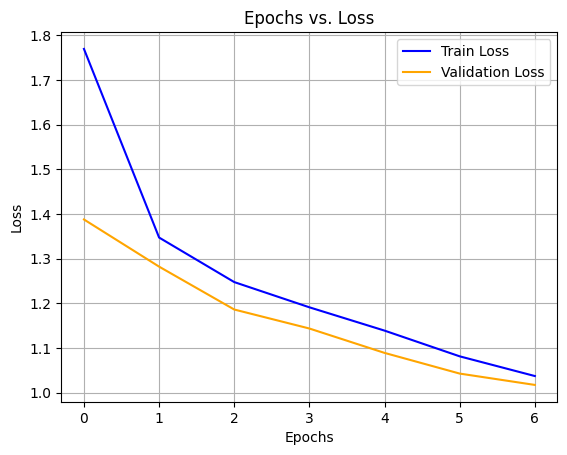

In [23]:
import matplotlib.pyplot as plt

x = list(range(7))

plt.plot(x, total_loss, label='Train Loss', color='blue')
plt.plot(x, validation_loss, label='Validation Loss', color='orange')

plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Epochs vs. Loss')  # fixed typo
plt.legend()
plt.grid(True)
plt.show()

In [24]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print("Accuracy:", accuracy_score(y_true, y_pred))
print("\nClassification Report:\n", classification_report(y_true, y_pred))
print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))

print(f'Classes: {encoder.classes_}')

Accuracy: 0.5854166666666667

Classification Report:
               precision    recall  f1-score   support

           0       0.47      0.69      0.56       960
           1       0.56      0.51      0.53       960
           2       0.60      0.60      0.60       960
           3       0.87      0.54      0.67       960

    accuracy                           0.59      3840
   macro avg       0.63      0.59      0.59      3840
weighted avg       0.63      0.59      0.59      3840


Confusion Matrix:
 [[663 166 116  15]
 [334 486 124  16]
 [197 138 580  45]
 [215  74 152 519]]
Classes: ['de' 'en' 'es' 'it']


In [ ]:
torch.save(model.state_dict(), 'models/final_model.pth')

In [ ]:
for i, (inputs, outputs) in enumerate(test_loader):
    torch.save(inputs, f'data/inputs_{i}.pt')
    torch.save(outputs, f'data/outputs_{i}.pt')